In [1]:
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType, Team
from requests import HTTPError
import matplotlib.pyplot as plt
import json
import time
from pprint import pprint


In [2]:
schedule_df = pd.read_csv("./2024_2025_season.csv")


schedule_df['start_time'] = pd.to_datetime(schedule_df['start_time'])
schedule_df['start_time_et'] = schedule_df['start_time'].dt.tz_convert("US/Eastern")
schedule_df['year']  = schedule_df['start_time_et'].dt.year
schedule_df['month'] = schedule_df['start_time_et'].dt.month
schedule_df['day']   = schedule_df['start_time_et'].dt.day
schedule_df['home_team'] = schedule_df['home_team'].str.replace(" ", "_")
schedule_df['away_team'] = schedule_df['away_team'].str.replace(" ", "_")
schedule_df['game_name'] = schedule_df['home_team']+"-"+schedule_df['away_team']+"-"+schedule_df['year'].astype(str)+"-"+schedule_df['month'].astype(str)+"-"+schedule_df['day'].astype(str)

nicely_formatted_current_time = time.strftime("%Y_%m_%d__%H_%M_%S", time.localtime())
attempt_name = f'all_data_{nicely_formatted_current_time}.json'

all_data_json = {}
i = 0  # if cut off halfway through change to be higher
if input("file maker?: press y").lower() == "y":
    while i < len(schedule_df['home_team']):
        try:
           
            data = json.loads(client.play_by_play(
                home_team=Team[schedule_df['home_team'][i]], 
                year=schedule_df['year'][i], 
                month=schedule_df['month'][i],
                day=schedule_df['day'][i], 
                output_type=OutputType.JSON
            ))
            all_data_json[schedule_df['game_name'][i]] = data
        
            with open(attempt_name, 'w') as json_file:
               json.dump(all_data_json, json_file, indent=4)
            
            
            time.sleep(1)
            print(i) #test to see if it works
            i += 1
        except HTTPError:
            nicely_formatted_current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            print(f'HTTPError at {nicely_formatted_current_time}, pausing for 1 minute, index={i}')
            time.sleep(60)
# all data has been collected in a file called all_data_{current date}.json





file maker?: press y 


In [3]:
def read_json(file_path="all_data_2025_06_07__20_05_56.json"):
    """
    with the data collected above, make a dictionary that is easy to use
    dictionary with 
    """
    with open(file_path) as f:
        return json.loads(f.read())

In [4]:
import re #Regular expressions, new thing I learned, my brother recommended me to use it for matching a specific string

def get_points(description):
    """
    gets the points from the description string
    """
    if 'free throw' in description:
        return 1
    
    match = re.search(r"makes (\d)", description)  # match.group(1) is number inside ()
    if match:
        return int(match.group(1))
    else:
        return False
    

In [5]:
   
def make_dunk_dicts():
    """
    multiple dunk analyses so we have get all the info easily accessible here
    """
    dunk_list = []
    for game_name, data in read_json().items():
        for play in data:
            desc = play.get("description").lower()
            dunk = {
                "game":          game_name,
                "period":        play.get("period"),
                "period_type":   play.get("period_type"),
                "clock_sec":     play.get("remaining_seconds_in_period"),
                "away_team":     play.get("away_team"),
                "home_team":     play.get("home_team"),
                "away_score":    play.get("away_score"),
                "home_score":    play.get("home_score"),
                "description":   desc
             }
            
            if "dunk" not in desc:
                continue


            relevant_team = play.get("relevant_team")
            other_team = play.get('away_team') if relevant_team == play.get("home_team") else play.get("home_team")
            
            if " makes " in desc:
                dunk["scorer"] = desc.split(" makes ")[0] +f"_{relevant_team}"
                
            assist_match = re.search(r"\(assist by ([^)]+)\)", desc) 
            # re.search() looks for a string that matches the regular expression, 
            # this matches strings that have assist by some non closing parenthisis 1+ letters
            if assist_match:
                dunk["assisted"]  = True
                dunk["assist_by"] = assist_match.group(1)+f"_{relevant_team}"
            else:
                dunk["assisted"]  = False
                dunk["assist_by"] = None
                
            if "at rim" in desc:
                dunk["distance_ft"] = 0
            else:
                distance_match = re.search(r"from (\d+) ft", desc)
                if distance_match:
                    dunk["distance_ft"] = int(distance_match.group(1))
                else:
                    dunk["distance_ft"] = None

            block_match = re.search(r"\(block by ([^)]+)\)", desc) 
            if block_match:
                dunk["blocked"]  = True
                dunk["block_by"] = block_match.group(1)+f"_{other_team}"
            else:
                dunk["blocked"]  = False
                dunk["block_by"] = None
                
            dunk_list.append(dunk)
    
    return dunk_list   
        
# print([(k, v) for k, v in read_json().items()][:20])


In [6]:
from collections import defaultdict

# find the longest dunk for each player
longest_dunk = defaultdict(int)
for dunk in make_dunk_dicts():
    if dunk.get('scorer', None) is not None:
        longest_dunk[dunk['scorer']] = max([longest_dunk[dunk['scorer']], dunk['distance_ft']])



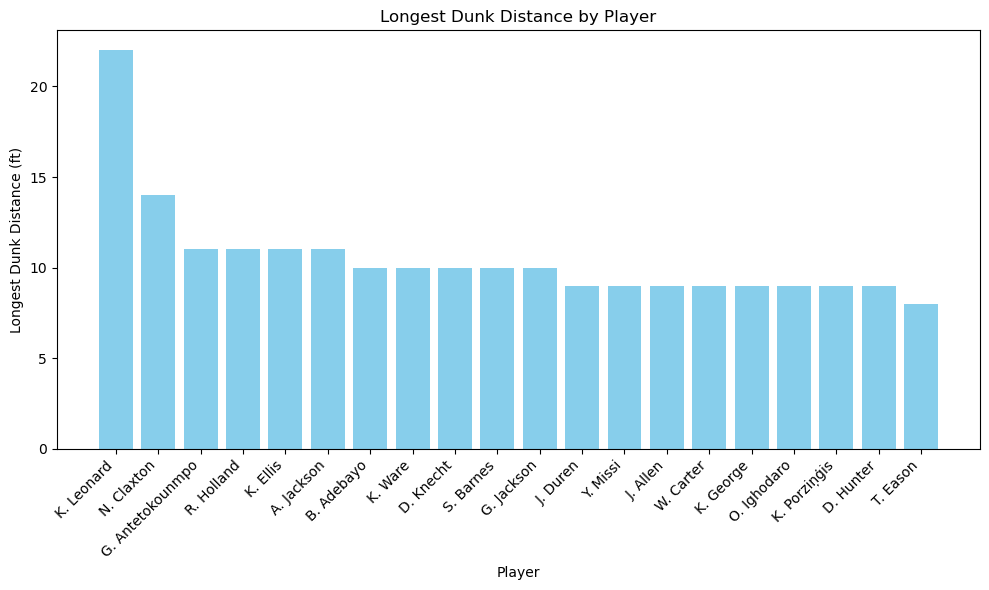

[('K. Leonard', 22), ('N. Claxton', 14), ('G. Antetokounmpo', 11), ('R. Holland', 11), ('K. Ellis', 11), ('A. Jackson', 11), ('B. Adebayo', 10), ('K. Ware', 10), ('D. Knecht', 10), ('S. Barnes', 10), ('G. Jackson', 10), ('J. Duren', 9), ('Y. Missi', 9), ('J. Allen', 9), ('W. Carter', 9), ('K. George', 9), ('O. Ighodaro', 9), ('K. Porziņģis', 9), ('D. Hunter', 9), ('T. Eason', 8)]


In [7]:
import matplotlib.pyplot as plt

players = list(longest_dunk.keys())
distances = [longest_dunk[player] for player in players]

TOP_PLAYERS = 20
players, distances = zip(*sorted(zip(players, distances), key=lambda x: x[1], reverse=True))
players = [player.split('_')[0].title() for player in players][:TOP_PLAYERS]
distances = distances[:TOP_PLAYERS]

plt.figure(figsize=(10, 6))
plt.bar(players, distances, color='skyblue')
plt.xlabel("Player")
plt.ylabel("Longest Dunk Distance (ft)")
plt.title("Longest Dunk Distance by Player")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(list(zip(players, distances)))
# youtube videos of incorrect data:
# https://youtu.be/rZUE9eMkY5E?t=407
# https://youtu.be/134Xo9fpIoY?t=317
# https://youtu.be/-XO_2K8uURM?t=288
# https://youtu.be/M67B7VEOeRg?t=288


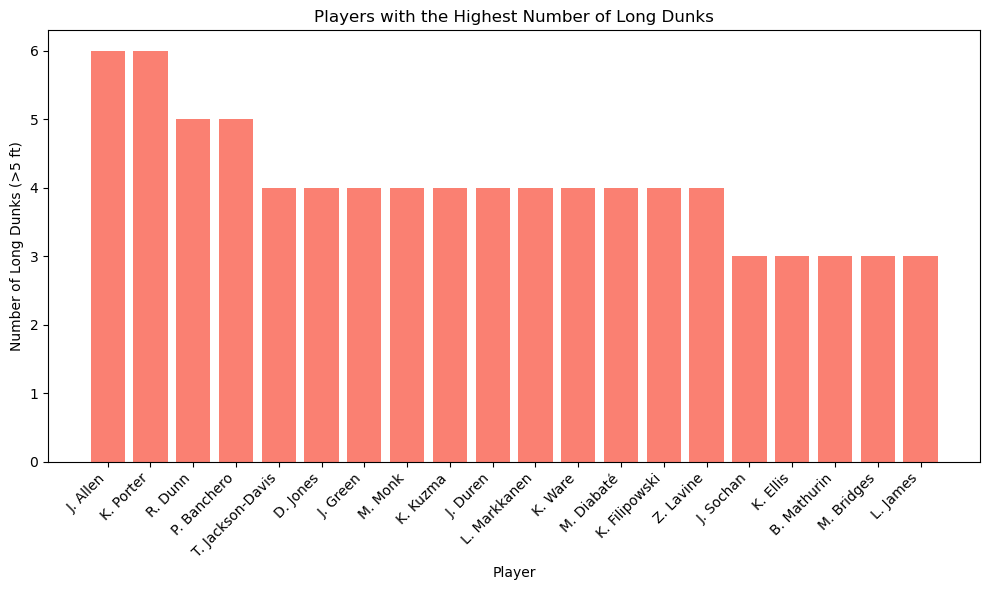

[('J. Allen', 6), ('K. Porter', 6), ('R. Dunn', 5), ('P. Banchero', 5), ('T. Jackson-Davis', 4), ('D. Jones', 4), ('J. Green', 4), ('M. Monk', 4), ('K. Kuzma', 4), ('J. Duren', 4), ('L. Markkanen', 4), ('K. Ware', 4), ('M. Diabaté', 4), ('K. Filipowski', 4), ('Z. Lavine', 4), ('J. Sochan', 3), ('K. Ellis', 3), ('B. Mathurin', 3), ('M. Bridges', 3), ('L. James', 3)]


In [8]:
# num long dunks per player
NUM_FEET = 5
long_dunk_count = defaultdict(int)
for dunk in make_dunk_dicts():
    if dunk.get('scorer') and dunk.get('distance_ft') is not None and dunk['distance_ft'] > NUM_FEET:
        long_dunk_count[dunk['scorer']] += 1

# Sort by most long dunks
players, counts = zip(*sorted(long_dunk_count.items(), key=lambda x: x[1], reverse=True))

TOP_PLAYERS = 20
players = [player.split('_')[0].title() for player in players[:TOP_PLAYERS]]
counts = counts[:TOP_PLAYERS]




# Plot
plt.figure(figsize=(10, 6))
plt.bar(players, counts, color='salmon')
plt.xlabel("Player")
plt.ylabel(f"Number of Long Dunks (>{NUM_FEET} ft)")
plt.title("Players with the Highest Number of Long Dunks")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(list(zip(players, counts)))


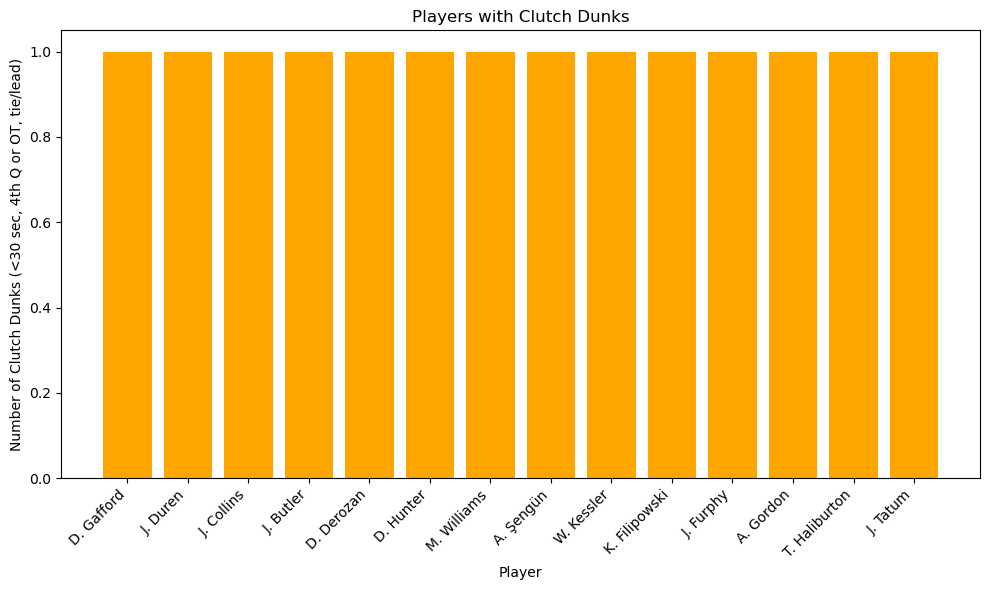

[('D. Gafford', 1), ('J. Duren', 1), ('J. Collins', 1), ('J. Butler', 1), ('D. Derozan', 1), ('D. Hunter', 1), ('M. Williams', 1), ('A. Şengün', 1), ('W. Kessler', 1), ('K. Filipowski', 1), ('J. Furphy', 1), ('A. Gordon', 1), ('T. Haliburton', 1), ('J. Tatum', 1)]


In [9]:
# num clutch dunks per player
clutch_dunk_count = defaultdict(int)
for dunk in make_dunk_dicts():
    if not dunk.get('scorer'):
        continue

    if dunk.get('period') != 4 and dunk.get('period_type') != "OVERTIME":
        continue

    if dunk.get('clock_sec') is None or dunk['clock_sec'] >= 30:
        continue

    relevant_team = dunk.get("away_team") if dunk['scorer'].endswith(dunk.get("away_team")) else dunk.get("home_team")
    other_team = dunk.get("home_team") if relevant_team == dunk.get("away_team") else dunk.get("away_team")
    scores = {dunk.get("home_team"): dunk.get("home_score"), dunk.get("away_team"): dunk.get("away_score")}
    
    points = 2  # All dunks are 2-point shots
    prev_score = scores[relevant_team] - points
    other_score = scores[other_team]

    if prev_score <= other_score and scores[relevant_team] >= other_score:
        clutch_dunk_count[dunk['scorer']] += 1


# sort by highest num clutch dunks
players, counts = zip(*sorted(clutch_dunk_count.items(), key=lambda x: x[1], reverse=True))

TOP_PLAYERS = 20
players = [player.split('_')[0].title() for player in players[:TOP_PLAYERS]]
counts = counts[:TOP_PLAYERS]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(players, counts, color='orange')
plt.xlabel("Player")
plt.ylabel("Number of Clutch Dunks (<30 sec, 4th Q or OT, tie/lead)")
plt.title("Players with Clutch Dunks")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(list(zip(players, counts)))
# youtube clips:
# https://youtu.be/Tp9xGpBToIM?t=526
# https://youtu.be/yF_1_SR0pfc?t=554
# https://youtu.be/acFRRjWLpdg?t=471
# https://youtu.be/taBykdn0Dvg?t=530
# https://youtu.be/qeqBKgK9ACs?t=500
# https://youtu.be/70KNujgJ7-g?t=543  # best one



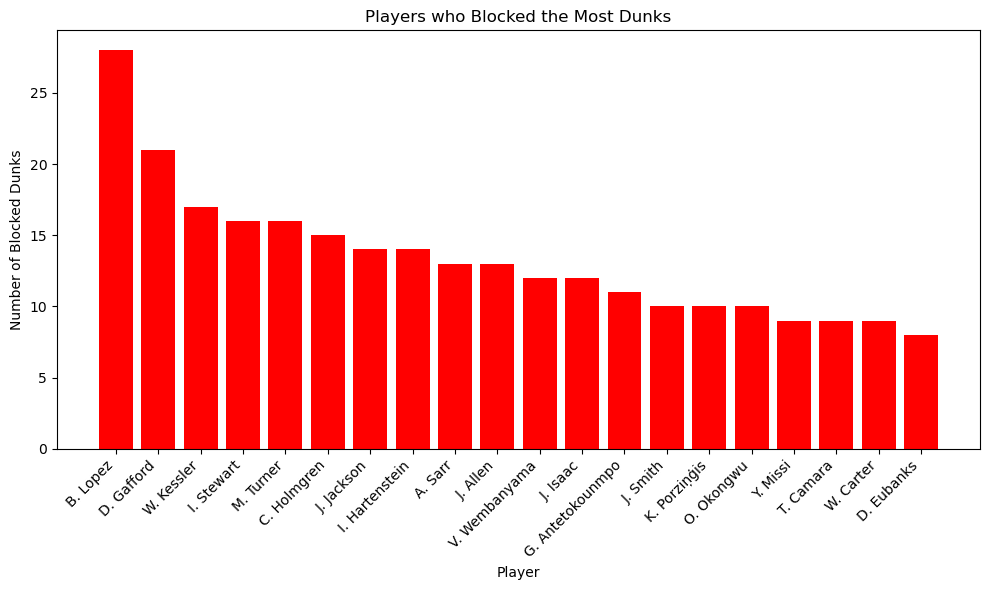

[('B. Lopez', 28), ('D. Gafford', 21), ('W. Kessler', 17), ('I. Stewart', 16), ('M. Turner', 16), ('C. Holmgren', 15), ('J. Jackson', 14), ('I. Hartenstein', 14), ('A. Sarr', 13), ('J. Allen', 13), ('V. Wembanyama', 12), ('J. Isaac', 12), ('G. Antetokounmpo', 11), ('J. Smith', 10), ('K. Porziņģis', 10), ('O. Okongwu', 10), ('Y. Missi', 9), ('T. Camara', 9), ('W. Carter', 9), ('D. Eubanks', 8)]


In [10]:
# num blocked dunks per player
blocked_dunk_count = defaultdict(int)
for dunk in make_dunk_dicts():
    if dunk.get('blocked'):
        blocked_dunk_count[dunk['block_by']] += 1

players, counts = zip(*sorted(blocked_dunk_count.items(), key=lambda x: x[1], reverse=True))

TOP_PLAYERS = 20
players = [player.split('_')[0].title() for player in players[:TOP_PLAYERS]]
counts = counts[:TOP_PLAYERS]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(players, counts, color='red')
plt.xlabel("Player")
plt.ylabel("Number of Blocked Dunks")
plt.title("Players who Blocked the Most Dunks")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(list(zip(players, counts)))



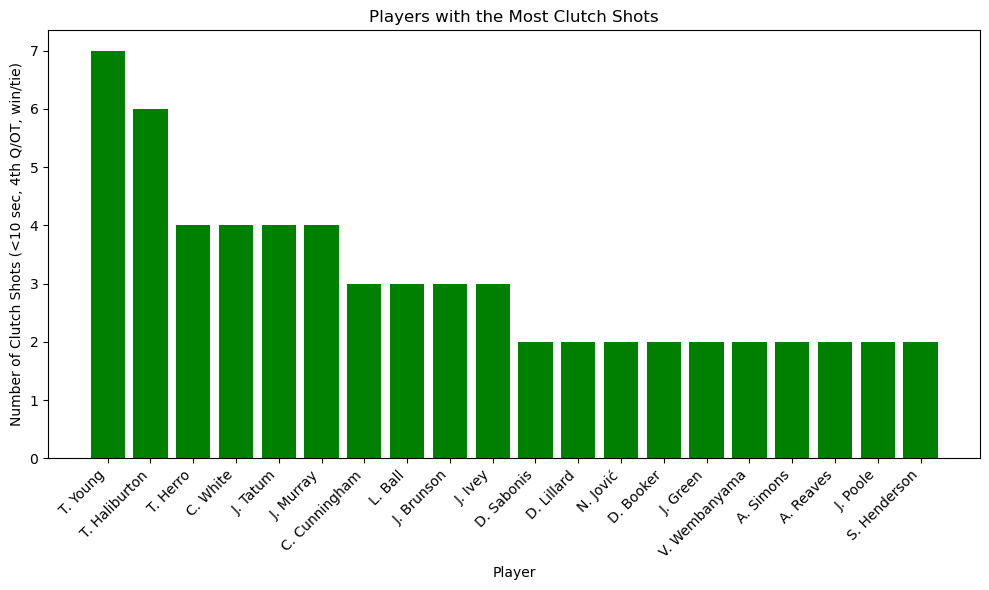

[('T. Young', 7), ('T. Haliburton', 6), ('T. Herro', 4), ('C. White', 4), ('J. Tatum', 4), ('J. Murray', 4), ('C. Cunningham', 3), ('L. Ball', 3), ('J. Brunson', 3), ('J. Ivey', 3), ('D. Sabonis', 2), ('D. Lillard', 2), ('N. Jović', 2), ('D. Booker', 2), ('J. Green', 2), ('V. Wembanyama', 2), ('A. Simons', 2), ('A. Reaves', 2), ('J. Poole', 2), ('S. Henderson', 2)]


In [15]:
clutch_shot_count = defaultdict(int)

for game_name, data in read_json().items():
    for play in data:
        desc = play.get("description", "").lower()
        if " makes " not in desc:
            continue

        if play.get("period") != 4 and play.get("period_type") != "OVERTIME":
            continue

        clock = play.get("remaining_seconds_in_period")
        if clock is None or clock >= 10:
            continue

        relevant_team = play.get("relevant_team")
        if relevant_team is None:
            continue
        other_team = play.get('away_team') if relevant_team == play.get("home_team") else play.get("home_team")

        points = get_points(desc)
        scores = {play.get("home_team"): play.get("home_score"), play.get("away_team"): play.get("away_score")}

        if scores[relevant_team] - points <= scores[other_team] and scores[relevant_team] >= scores[other_team]:
            scorer = desc.split(" makes ")[0] + f"_{relevant_team}"
            clutch_shot_count[scorer] += 1

players, clutch_counts = zip(*sorted(clutch_shot_count.items(), key=lambda x: x[1], reverse=True))

TOP_PLAYERS = 20
players = [player.split('_')[0].title() for player in players[:TOP_PLAYERS]]
clutch_counts = clutch_counts[:TOP_PLAYERS]

plt.figure(figsize=(10, 6))
plt.bar(players, clutch_counts, color='green')
plt.xlabel("Player")
plt.ylabel("Number of Clutch Shots (<10 sec, 4th Q/OT, win/tie)")
plt.title("Players with the Most Clutch Shots")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(list(zip(players, clutch_counts)))


In [ ]:
import os

import random



JSON_PATH = "all_data_2025_06_07__20_05_56.json"

# compile regexes once
re_block = re.compile(r"\(block by ([^)]+)\)")
re_dist  = re.compile(r"from (\d+) ft")

def analyze_dunks(path):
    """
      - longest dunk distance
      - count of dunks > 5 ft
      - clutch dunks (<10s in 4th or OT)
      - times they blocked a dunk
    """
    longest      = defaultdict(int)
    long_count   = defaultdict(int)
    clutch_count = defaultdict(int)
    blocked      = defaultdict(int)
    
players = set(longest_dunk) | set(long_dunk_count) | set(clutch_dunk_count) | set(blocked_dunk_count)
stats = {
    p: {
        "longest dunk":   longest_dunk.get(p, 0),
        ">5ft dunks":     long_dunk_count.get(p, 0),
        "clutch dunks":   clutch_dunk_count.get(p, 0),
        "blocked dunks":  blocked_dunk_count.get(p, 0),
    }
    for p in players
}


def play_game(stats):
    """
    pick two players & a stat, ask who’s higher.
    Clears screen each round, never shows ties.
    """
    score = 0
    input("Press Enter to start the NBA Guessing Game...")

    while True:
        os.system('clear')

        # pick a non‐tie matchup
        while True:
            p1, p2 = random.sample(list(stats), 2)
            stat = random.choice(list(stats[p1].keys()))
            v1, v2 = stats[p1][stat], stats[p2][stat]
            if v1 != v2:
                break
                
        print(f"Who has more {stat}?")
        print(f"  A) {" --- ".join(p1.split("_")).title()}    B) {" on the ".join(p2.split("_")).title()}")
        choice = input("Your guess (A/B), or Q to quit: ").strip().upper()

        if choice == "Q":
            break
        if choice not in ("A", "B"):
            continue

        correct = (v1 > v2 and choice == "A") or (v2 > v1 and choice == "B")
        if correct:
            score += 1
            print(f"✅ Correct!  {p1}: {v1} vs {p2}: {v2}")
        else:
            print(f"❌ Nope.     {p1}: {v1} vs {p2}: {v2}")

        print(f"\nScore: {score}")
        input("Press Enter for the next round...")

    os.system('clear')
    print(f"Game over! Your final score: {score}")

if __name__ == "__main__":
    play_game(stats)

Press Enter to start the NBA Showdown... 


Who has more >5ft dunks?
  A) J. Green--- New Orleans Pelicans    B) L. Nance On The Atlanta Hawks
